In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
struktura_ludnosci = pd.ExcelFile('data/struktura_ludnosci.xls').parse(0)
struktura_ludnosci = struktura_ludnosci.drop([0, 1, 2, 4])
struktura_ludnosci = struktura_ludnosci.transpose()
struktura_ludnosci = struktura_ludnosci.reset_index().drop(columns=['index'])
struktura_ludnosci.columns = struktura_ludnosci.iloc[0]
struktura_ludnosci.drop(index=0, inplace=True)
struktura_ludnosci = struktura_ludnosci.set_index('Grupy wieku')
struktura_ludnosci.index.names = ['Rok']
struktura_ludnosci.index = struktura_ludnosci.index.astype(np.int64)
struktura_ludnosci = struktura_ludnosci.loc[:, :'Kobiety w wieku rozrodczym 15 - 49 lat          ']
struktura_ludnosci.rename(columns=lambda x: str(x).strip(), inplace=True)
struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'] = struktura_ludnosci['Kobiety w wieku rozrodczym 15 - 49 lat'] / struktura_ludnosci['OGÓŁEM']

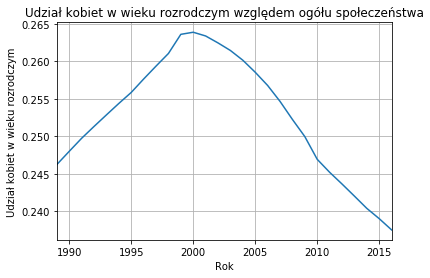

In [3]:
ax = struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'].plot(title='Udział kobiet w wieku rozrodczym względem ogółu społeczeństwa')
ax.set_ylabel('Udział kobiet w wieku rozrodczym');
ax.grid();
plt.savefig('img/udzial_kobiet_w_wieku_rozrodczym.png')

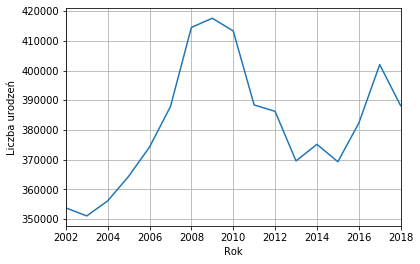

In [4]:
uro = pd.read_csv('data/urodzenia_zywe.csv', sep=';')
uro.drop(['Kod', 'Nazwa', 'Wiek matki', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], axis=1).plot('Rok', 'Wartosc', legend=False);
plt.ylabel('Liczba urodzeń');
plt.grid()
plt.savefig('img/liczba_urodzen.png', dpi=300)

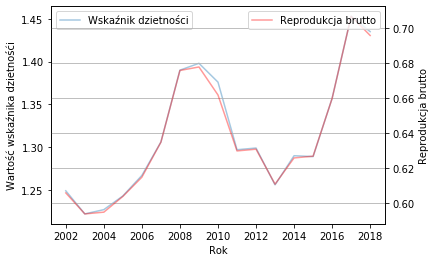

In [5]:
wsp_dziet = pd.read_csv('data/wspolczynnik_dzietnosci.csv', sep=';')
wsp_dziet.drop(['Kod', 'Nazwa', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True, axis=1)
wsp_dziet['Wartosc'] = wsp_dziet['Wartosc'].apply(lambda x: float(x.replace(',', '.')))

dziet_plot_data = wsp_dziet[wsp_dziet['Współczynniki'] == 'dzietność'].drop('Współczynniki', axis=1)
rep_brutto = wsp_dziet[wsp_dziet['Współczynniki'] == 'reprodukcja brutto'].drop('Współczynniki', axis=1)

fig, ax = plt.subplots()
ax.plot(dziet_plot_data['Rok'], dziet_plot_data['Wartosc'], alpha=.4, label='Wskaźnik dzietności')
ax.set_xlabel('Rok')
ax.set_ylabel('Wartość wskaźnika dzietnośći')
ax.legend(loc='best')

ax2 = ax.twinx()
ax2.plot(rep_brutto['Rok'], rep_brutto['Wartosc'], color='red', alpha=.4, label='Reprodukcja brutto')
ax2.set_ylabel('Reprodukcja brutto')
ax2.set_xlabel('Rok')
ax2.legend(loc='upper right')
plt.grid()
fig.savefig('img/wsk_dzien_vs_repr_brutto.png')

plt.show()

In [6]:
dzietnosc = pd.ExcelFile('data/dzietnosc_kobiet.xls').parse(0)
old_col_names = dzietnosc.columns
new_col_names = ['year', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 'fertility_rate', 'median_age_first_child', 'mean_age', 'mean_age_first_child']
colnames = dict(zip(old_col_names, new_col_names))
dzietnosc.rename(columns=colnames, inplace=True)
dzietnosc = dzietnosc.iloc[4:-3]
dzietnosc.replace('...', np.nan, inplace=True)
dzietnosc.set_index('year', inplace=True)

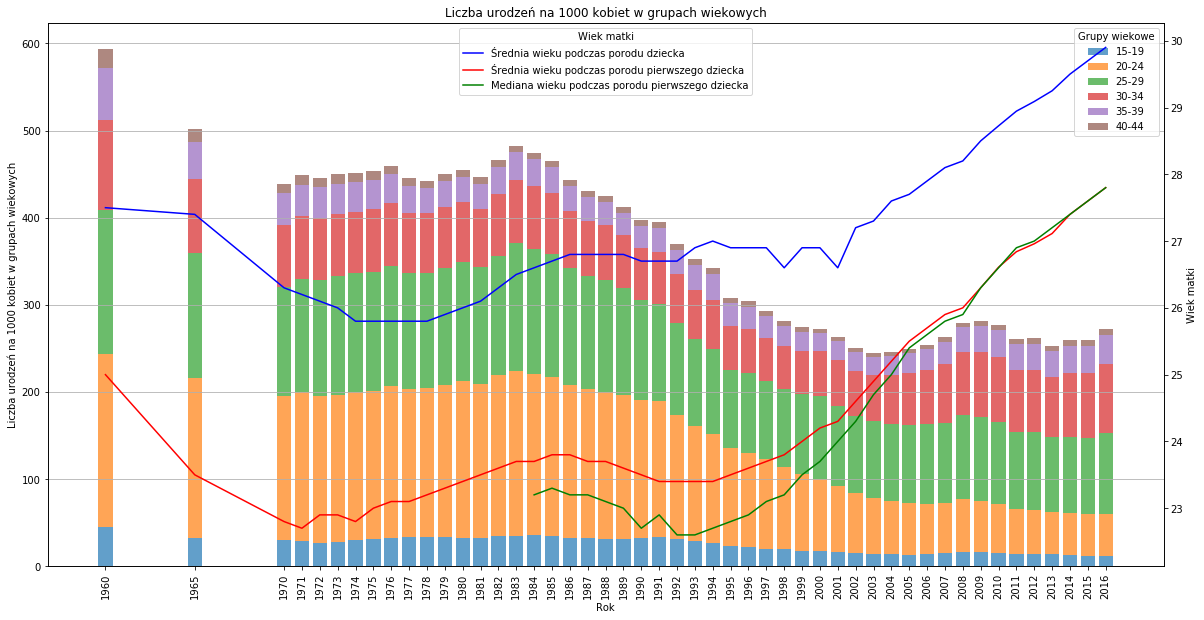

In [7]:
age_groups = dzietnosc.columns[:-5]
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_xticklabels(dzietnosc.index, rotation=90)
ax.set_xticks(dzietnosc.index)
ax.set_title('Liczba urodzeń na 1000 kobiet w grupach wiekowych')
ax.set_xlabel('Rok')
ax.set_ylabel('Liczba urodzeń na 1000 kobiet w grupach wiekowych')
for i in range(len(age_groups)):
    ax.bar(dzietnosc.index, dzietnosc[age_groups[i]], label=age_groups[i], bottom=np.array(dzietnosc[age_groups[:i]].sum(axis=1)), alpha=.7)

ax.legend(title='Grupy wiekowe')
ax.yaxis.grid()
ax2 = ax.twinx()
ax2.set_ylabel('Wiek matki')
ax2.plot(dzietnosc['mean_age'], color='blue', label='Średnia wieku podczas porodu dziecka')
ax2.plot(dzietnosc['mean_age_first_child'], color='red', label='Średnia wieku podczas porodu pierwszego dziecka')
ax2.plot(dzietnosc['median_age_first_child'], color='green', label='Mediana wieku podczas porodu pierwszego dziecka')
ax2.legend(title='Wiek matki', loc='upper center')
fig.savefig('img/liczba_urodzen_na_1000_kobiet.png')
plt.show()

Na wykresie powyżej widać, że kobiety rodzą coraz mniej dzieci oraz robią to w coraz późniejszym momencie swojego życia. Można z tego wywnioskować, że w dalszej przyszłości niż demograficzny może być problemem dla ośrodków pomocy społecznej. Byłby to jednak wniosek wysnuty na podstawie niepełnych informacji. Warto dodatkowo przyjrzeć się średniej długości życia w Polsce oraz jej prognozom.

Dodatkowo pooczątki niżu demograficznego możemy zaobserwować na początku lat 90-tych. We wcześniejszych rocznikach obserwowano dużo większą liczbę urodzeń i właśnie te roczniki mogą stanowić grupę docelową w bliższej przyszłości (np. ludność urodzona w latach 1960-1965)

In [8]:
def plot_lineplot_demand(filename, figtitle, plottitles, imgname):
    zakl = pd.read_csv('data/{}.csv'.format(filename), sep=';')
    zakl.drop(columns=['Nazwa', 'Kod', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True)
    zakl.set_index(['Wykaz'], inplace=True)
    zakl['Rok'] = zakl['Rok'].astype(np.int64)
    zakl = zakl[zakl['Rok'] >= 2010]

    fig, ax = plt.subplots(1, 2)
    fig.suptitle(figtitle, y=.95)
    ax[0].grid()
    ax[0].plot(zakl.loc['ogółem']['Rok'], zakl.loc['ogółem']['Wartosc'])
    ax[0].set_xlabel('Rok')
    ax[0].set_title(plottitles[0])
    ax[1].plot(zakl.loc['łóżka stan w dniu 31.12']['Rok'], zakl.loc['łóżka stan w dniu 31.12']['Wartosc'], label='Ilość łóżek')
    ax[1].set_title(plottitles[1])
    ax[1].set_xlabel('Rok')
    ax[1].plot(zakl.loc['pacjenci']['Rok'], zakl.loc['pacjenci']['Wartosc'], label='Ilość pacjentów')
    ax[1].fill_between(zakl.loc['pacjenci']['Rok'], zakl.loc['łóżka stan w dniu 31.12']['Wartosc'], zakl.loc['pacjenci']['Wartosc'], alpha=.3, color='lightblue')
    ax[1].legend()
    ax[1].grid()
    fig.set_size_inches(20, 10)
    fig.savefig('img/{}.png'.format(imgname))

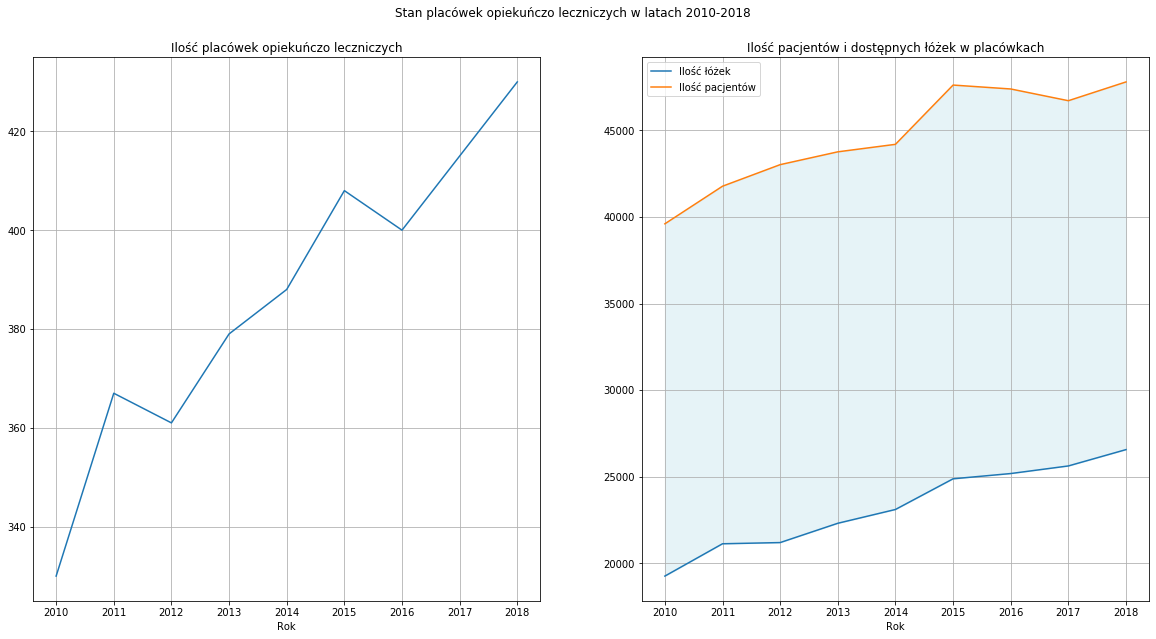

In [9]:
plot_lineplot_demand(
    'zaklady_opiekunczo_lecznicze',
    'Stan placówek opiekuńczo leczniczych w latach 2010-2018',
    ['Ilość placówek opiekuńczo leczniczych', 'Ilość pacjentów i dostępnych łóżek w placówkach'],
    'pl_op_lecz'
)

Można policzyć ile średnio przypada łóżek i pacjentów na placówkę i ile łóżek brakuje

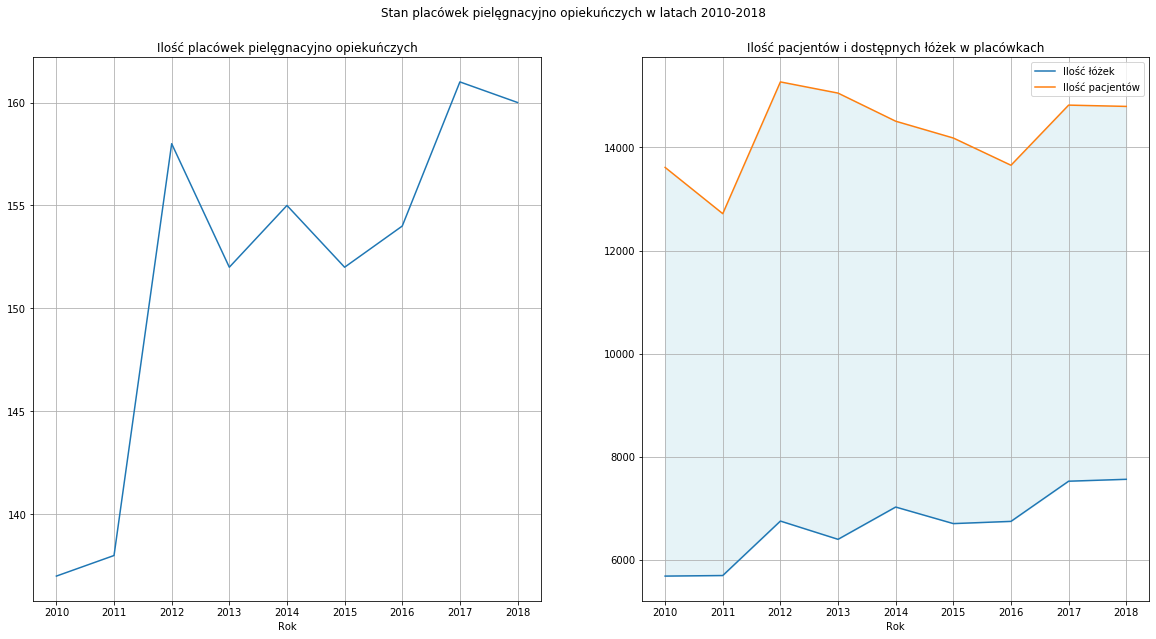

In [10]:
plot_lineplot_demand(
    'zaklady_pielegnacyjno_opiekuncze',
    'Stan placówek pielęgnacyjno opiekuńczych w latach 2010-2018',
    ['Ilość placówek pielęgnacyjno opiekuńczych', 'Ilość pacjentów i dostępnych łóżek w placówkach'],
    'pl_piel_op'
)

Pomimo wzrostu ilości placówek, ilość pacjentów bez przydzielonego miejsca nadal pozostaje na podobnym poziomie

In [11]:
life_exp = pd.read_csv('data/przecietne_dalsze_trwanie_zycia.csv', sep=';').drop(columns=['Kod', 'Nazwa', 'Lokalizacje', 'Jednostka miary', 'Atrybut', 'Unnamed: 9']).set_index(['Płeć']).dropna()
life_exp['Wartosc'] = life_exp['Wartosc'].apply(lambda x: float(x.replace(',', '.')))

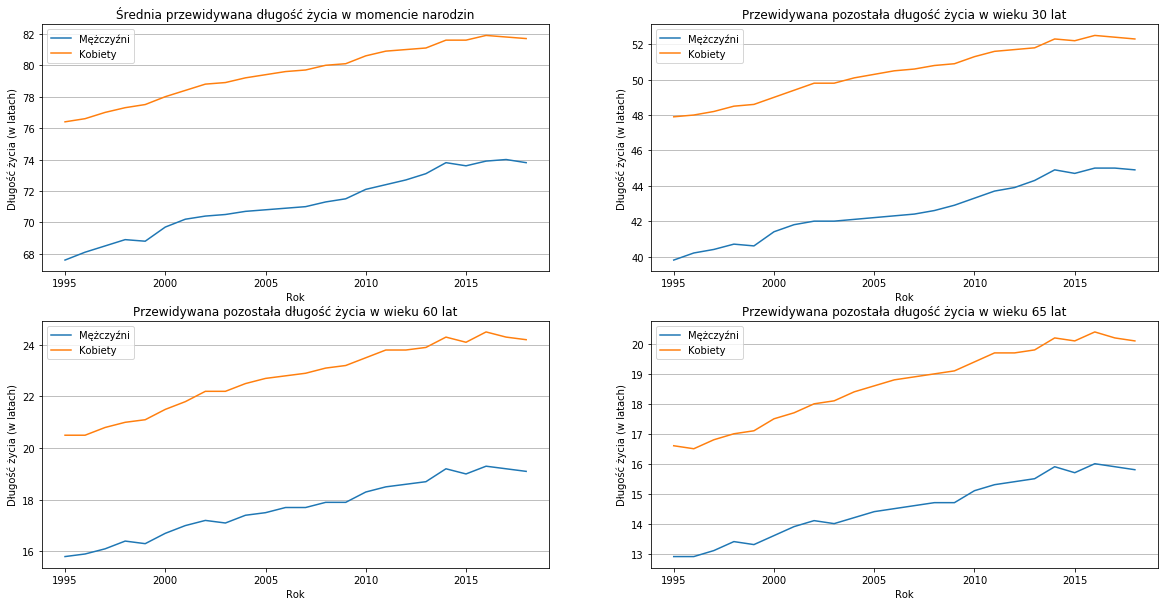

In [12]:
fig, ax = plt.subplots(2, 2);
fig.set_size_inches(20, 10);
ax = ax.flatten();

for age in enumerate([0, 30, 60, 65]):
    plt_data = life_exp[life_exp['Wiek'] == age[1]]
    ax[age[0]].plot(plt_data.loc['mężczyźni', 'Rok'], plt_data.loc['mężczyźni', 'Wartosc'], label='Mężczyźni')
    ax[age[0]].plot(plt_data.loc['kobiety', 'Rok'], plt_data.loc['kobiety', 'Wartosc'], label='Kobiety')
    ax[age[0]].legend()
    ax[age[0]].set_title('Średnia przewidywana długość życia w momencie narodzin' if age[1] == 0 else 'Przewidywana pozostała długość życia w wieku {} lat'.format(age[1]))
    ax[age[0]].set_xlabel('Rok')
    ax[age[0]].set_ylabel('Długość życia (w latach)')
    ax[age[0]].yaxis.grid()
    
fig.savefig('img/life_exp.png')

In [13]:
def prepare_plot_data(plot_data):
    cols = plot_data.columns.to_list()
    cols = cols[:1] + cols[9:10] + cols[1:9] + cols[10:]
    step = len(cols) // 3
    plot_data = plot_data[cols]

    cols = plot_data.columns
    for i in range(0, len(cols)-3, step):
        colname = '{}-{}'.format(cols[i].split('-')[0], (cols[i+step-1].split('-')[1] if '-' in cols[i+step-1] else cols[i+step-1]))
        plot_data[colname] = plot_data.iloc[:, i:i+step].sum(axis=1)

    return plot_data.iloc[:, -3:]

In [14]:
def plot_pop_bar_stacked(plot_data, title, filename):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    ax.set_xticklabels(plot_data.index, rotation=90)
    ax.set_xticks(plot_data.index)
    ax.set_title(title)
    ax.set_xlabel('Rok')
    ax.set_ylabel('Liczba populacji (w mln)')
    for i in range(len(plot_data.columns)):
        ax.bar(plot_data.index, plot_data[plot_data.columns[i]], label=plot_data.columns[i], bottom=np.array(plot_data[plot_data.columns[:i]].sum(axis=1)))

    ax.legend(title='Grupy wiekowe')
    ax.yaxis.grid()

    fig.savefig('img/{}.png'.format(filename))
    plt.show()

/home/marcin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


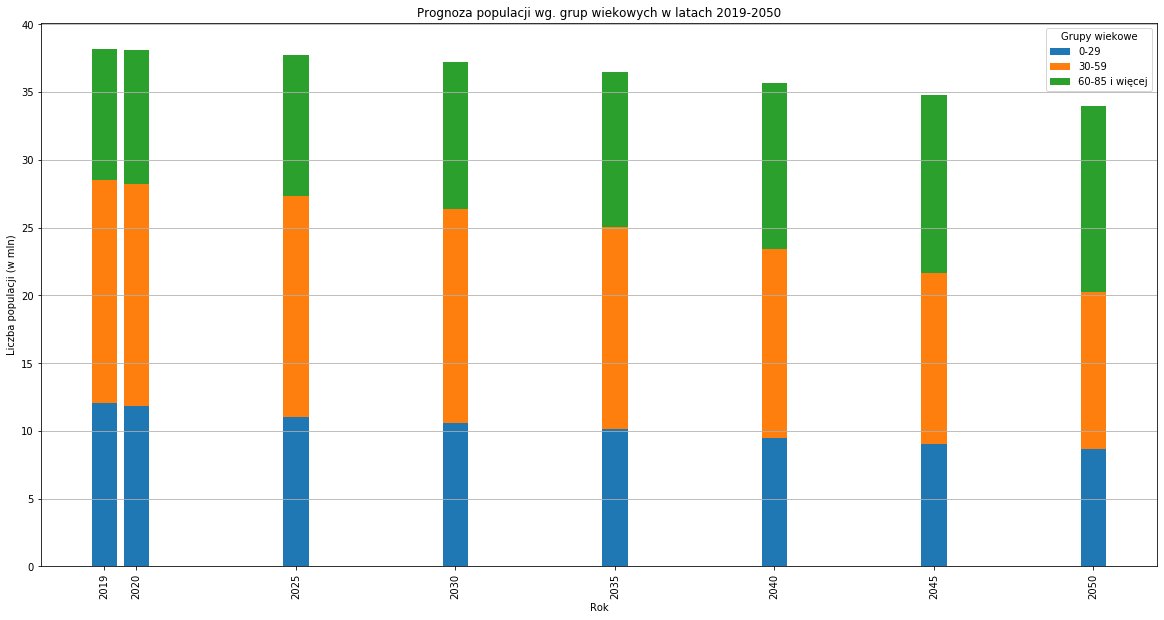

In [15]:
prog = pd.read_csv('data/prognoza_ludnosci.csv', sep=';').drop(columns=['Unnamed: 10', 'Atrybut', 'Jednostka miary', 'Płeć', 'Miejsce zamieszkania', 'Nazwa', 'Kod', 'Rok'])
prog['Rok'] = prog['Prognoza na rok'].apply(lambda x: int(x.split(' ')[-1]))
prog.drop(columns=['Prognoza na rok'], inplace=True)
plot_data = prepare_plot_data(prog.pivot_table(values='Wartosc', index='Rok', columns='Wiek', aggfunc=lambda x: x/1000000))
plot_pop_bar_stacked(plot_data, 'Prognoza populacji wg. grup wiekowych w latach 2019-2050', 'prognoza_populacji')

In [16]:
plot_data.loc[2050, '60-85 i więcej'].sum()

13.699786999999999

/home/marcin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


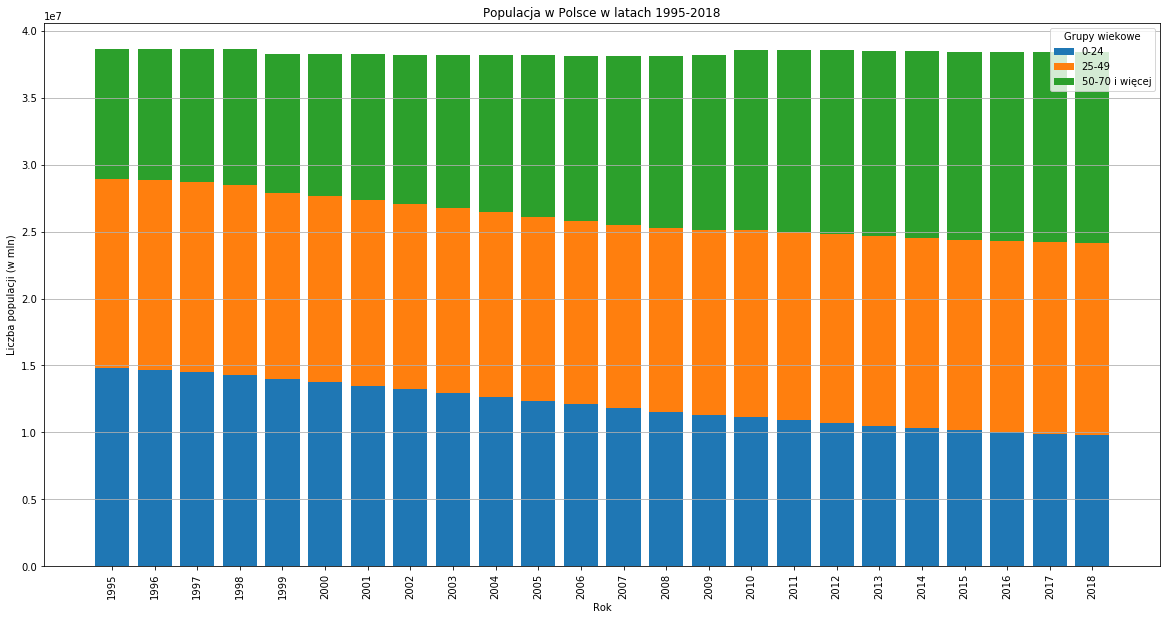

In [17]:
pop = pd.read_csv('data/ludnosc_wiek_rok.csv', ';')
plot_data = prepare_plot_data(pop.pivot_table(values='Wartosc', index='Rok', columns='Wiek').drop(columns=['0-14', '70-74', '75-79', '80-84', '85 i więcej']))
plot_pop_bar_stacked(plot_data, 'Populacja w Polsce w latach 1995-2018', 'populacja')

In [18]:
money = pd.read_csv('data/wynagrodzenia.csv', sep=';')
money['Wartosc'] = money['Wartosc'].apply(lambda x: float(str(x).replace(',', '.')))
money = money.iloc[0:-1]

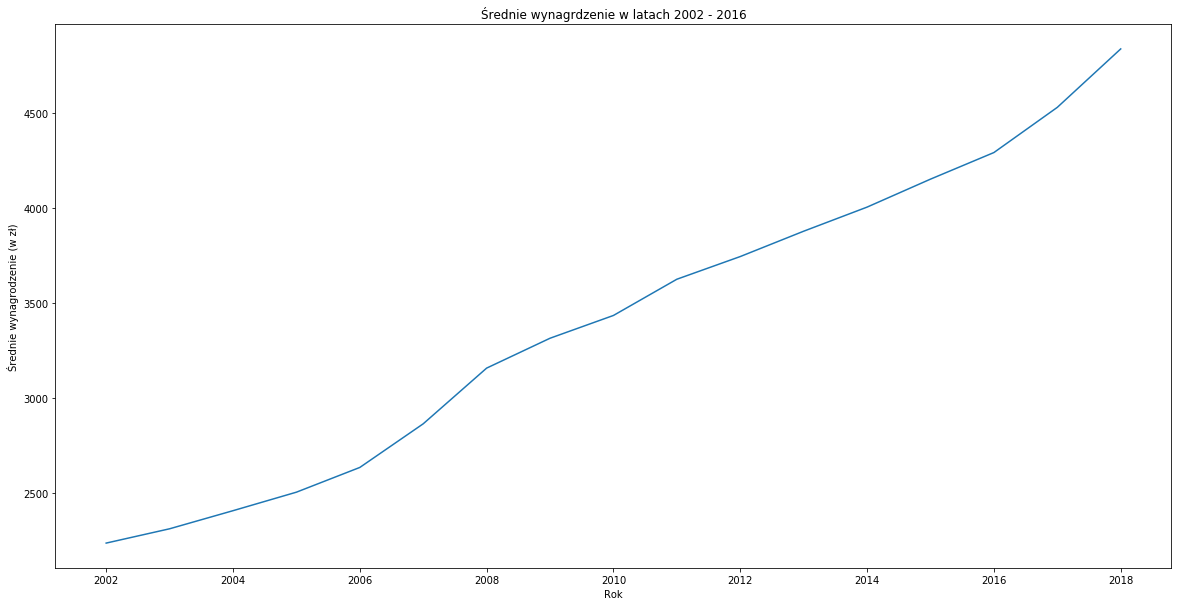

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(money['Rok'], money['Wartosc'])
plt.xlabel('Rok')
plt.ylabel('Średnie wynagrodzenie (w zł)')
plt.title('Średnie wynagrdzenie w latach 2002 - 2016')
plt.savefig('img/money.png')